In [1]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from scipy import ndimage
import pickle

%matplotlib inline

In [2]:
assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -f data
!ln -s '/content/drive/MyDrive/proj2_data' data

#some utility

In [4]:
def collate_fn1(batch):
    return tuple(zip(*batch))

def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        if turb_type=='turbulence':
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes2 = to_2d_tensor(boxes2)
    boxes2 = xywh_to_x1y1x2y2(boxes2)
    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, theta=0.75):
    IoU = compute_IoU(preds.clone(), targets.clone())
    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        
def box_to_mask(box, im_size):
    mask = np.zeros(im_size)
    co = xywh_to_x1y1x2y2(box)[0].type(torch.int64)
    mask[co[0]: co[2], co[1]: co[3]] = 1
    return Image.fromarray(np.uint8(mask*255).T)

def mask_to_box(mask):
    mask = torch.nonzero(mask[0, :, :].T != 0, as_tuple=False)
    x1, y1 = torch.min(mask, dim=0).values
    x2, y2 = torch.max(mask, dim=0).values
    return x1y1x2y2_to_xywh([x1, y1, x2, y2])[0]

#### ROI_PROPOSAL_ALGORITHM
def extractImgbyRoI(img, Coords):
  (x_min, y_min, x_max, y_max) = Coords[0]
  result = img[:, y_min:y_max, x_min:x_max]
  for i in range(1, len(Coords)):
    (x_min, y_min, x_max, y_max) = Coords[i]
    result = np.concatenate((result, img[:, y_min:y_max, x_min:x_max]), axis=2)
  return np.array(result)

def myImgShow(img):
  img = img.transpose((1, 2, 0))/255
  #img = img.numpy().transpose((1, 2, 0))/255
  plt.imshow(img)

def constructNeighbourGrid():
  size = 10
  neighbourGrid = []
 
  for i in range(size):
    for j in range(size):
      background = np.zeros((10, 10))
      #background[i][j] = 1
      # Dilation
      if i-1 >= 0: background[i-1][j] = 1
      if i+1 < size: background[i+1][j] = 1
      if j-1 >= 0: background[i][j-1] = 1
      if j+1 < size: background[i][j+1] = 1

      background = background.flatten()
      neighbourGrid.append(background == 1)

  return np.array(neighbourGrid)

def initCoord(img, size):
  _, h, w = img.shape
  sub_h, sub_w = math.floor(h/size), math.floor(w/size)
  RoIs = np.array([[[j*sub_w, i*sub_h, (j+1)*sub_w-1, (i+1)*sub_h-1] for j in range(size)] for i in range(size)])
  RoIs = RoIs.reshape(size*size, 4)
  return RoIs
    

def initRegions(size):
  return set([(i) for i in range(size)])


def regionsToCoord(Coords, regions):
  regions_list = tuple2list(regions)
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res


def regionsToCoord_test(Coords, regions):
  print(regions)
  regions_list = tuple2list(regions)
  print(regions_list[0])
  print(Coords[regions_list[0]].reshape(1, 4))
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res


def getHist(img):
  D, _, _ = img.shape
  histogram = []
  for channel_idx in range(D):
    h, _ = np.histogram(img[channel_idx, :, :], bins=25)
    histogram = histogram + list(h)
  histogram = np.array(histogram/np.linalg.norm(histogram, 1))
  return histogram

def sim(region1, region2):
  histogram1 = getHist(region1)
  histogram2 = getHist(region2)

  sim = np.vstack((histogram1, histogram2))
  sim = np.amin(sim, 0)
  sim = sim.sum()

  return sim

def findNeighbour(regions, size):
  neighbourGrid = np.zeros((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 1
  neighbourGrid = neighbourGrid.reshape((size, size))
  neighbourGrid = ndimage.binary_dilation(neighbourGrid).astype(neighbourGrid.dtype)
  neighbourGrid = neighbourGrid.reshape((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 0
  return np.where(neighbourGrid == 1)[0]

def tuple2list(input):
  if type(input) == int:
    return [input]
  res = []
  for element in input:
    if type(element) == tuple:
      res = res + list(element)
    else:
      res.append(element)
  return res

def removeEnclosedRegion(regions, newR):
  redundance = set()
  for t in regions:
    if set(t).issubset(newR):
      redundance.add(t)

  regions.symmetric_difference_update(redundance)
  return regions

def cropRect(RoIs, regions):
  res = RoIs
  for region in regions:
    coords = regionsToCoord(RoIs, region)

    coord_max = np.amax(coords, axis=0)
    coord_min = np.amin(coords, axis=0)

    vector = [coord_min[0], coord_min[1], coord_max[2], coord_max[3]]
    res = np.vstack((res, vector))

  return np.array(res)




In [5]:
def genRoIsperImg(im, size): 
  RoIs = initCoord(im, size)
  regions = initRegions(size*size)

  neighbourGrid = constructNeighbourGrid()

  simGrid = set()
  for i in range(size*size):
    for j in range(i, size*size):
      if neighbourGrid[i][j]:
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, [i]))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [j]))
        simGrid.add((i, j, sim(img1, img2)))

  regions_merged = set()
  current_merged_regions = set()
  i = 0
  while len(simGrid) > 0:
  #for i in range(20):
    # print('itr#:', i, " with size= ", len(simGrid))
    i = i+1
    region1, region2, _ = max(simGrid, key=lambda x:x[2])
    #print("region1 = ", region1)
    #print("region2 = ", region2)
    newRegion = set()
    newRegion.update(tuple2list(region1))
    newRegion.update(tuple2list(region2))
    regions_merged.add(tuple(newRegion))
    current_merged_regions = removeEnclosedRegion(current_merged_regions, tuple(newRegion))
    current_merged_regions.add(tuple(newRegion))
    removeList = list(filter(lambda x: x[0] == region1 or x[1] == region1, simGrid))
    #print("remove one = ", removeList)
    c1 = len(removeList)
    simGrid.difference_update(removeList)
    removeList = list(filter(lambda x: x[0] == region2 or x[1] == region2, simGrid))
    #print("remove two = ", removeList)
    c1 = c1 + len(removeList)
    #print("no of removal = ", c1)
    simGrid.difference_update(removeList)

    neighbourRegions = findNeighbour(newRegion, 10)
    #print("neigbour regions = ", neighbourRegions)
    for j in range(len(neighbourRegions)):
      neighbourRegion = neighbourRegions[j]
      #print("==== current neibh = ", neighbourRegion)
      counted = False
      for region in filter(lambda x: neighbourRegion in x, current_merged_regions):
        #print("region = ", region)
        counted = True
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, region))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

      if counted:
        #print(neighbourRegion, ' is counted')
        continue

      for region in filter(lambda x:x==neighbourRegion, regions):
        #print("single region = ", region)
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [region]))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

    if len(simGrid) <= 0:
      break
  
  res = cropRect(RoIs, regions_merged)
  res = set([tuple(ele) for ele in res])
  res = np.array(list(res))
  # print("finish")
  return res
    #print(regions_merged)
    #print(len(simGrid))

# define dataset

In [7]:
class MyDataset(Dataset):
    def __init__(self, datatype='train', transform=None):
        with open('data/bbox_'+datatype+'.csv') as f:
            id_to_box = dict()
            id_to_path = dict()
            id_to_turb= dict()
            last_name='none'
            idx=-1
            for line in f.read().splitlines():
                filename, wid, hei, turb, *box = line.split(',') # get all variable
                if turb =='severe turbulence':
                  turb_no=2
                else:
                  turb_no=1
                if filename == 'filename': # skip the title
                  continue

                if filename==last_name:
                  id_to_box[idx].append(list(map(float, box)))
                  id_to_turb[idx].append(turb_no)
                  
                else:
                  idx=idx+1
                  id_to_path[idx]=filename
                  id_to_box[idx]=[list(map(float, box))]
                  id_to_turb[idx]=[turb_no]
                  last_name=filename

            self.imgs = [(os.path.join('data/'+datatype, id_to_path[i]), id_to_box[i],id_to_turb[i])
                     for i in range(len(id_to_path))]

            #transform data
            self.target_transform = transforms.Compose([
                transforms.Resize((840, 840)),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose([
                self.target_transform,
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            if transform is not None:
                self.transform = transforms.Compose([
                    transform,
                    self.transform
                ])
                self.target_transform = transforms.Compose([
                    transform,
                    self.target_transform
                ])

    def prepare_data(self, path):
      

      self.data = []
      img_count = 1
      for img in self.imgs:
        # if img_count == 5:
        #   break
        print("processing image#: ", img_count)
        img_count = img_count+1
        path, box, turb = img
        im = (np.load(path))/292*255
        im=np.transpose(im,(1, 2, 0))
        im=np.uint8(im)
        boxes = np.array(box, dtype='int32')
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        PIL = transforms.ToPILImage()(im).convert('RGB')#if you want to output 4 dimension data, change to .convert('RGBA'). While you will not able to do transforms.Normalize()
        im = self.transform(PIL)

        v = genRoIsperImg(im, 10)


        proposed_roi_lable = []
        for i in v:
          IoU_list = []
          for gt_box in box:
            IoU = compute_IoU(i, gt_box)
            IoU_list.append(IoU)
          most_likely_gt_box_iou_score = max(IoU_list)
          most_likely_gt_index = IoU_list.index(most_likely_gt_box_iou_score)
          gt_box_coord = box[most_likely_gt_index]
          if most_likely_gt_box_iou_score > 0:
            gt_box_class = turb[most_likely_gt_index]
          else:
            gt_box_class = 0
          
          gt_box_coord_xywh = np.array([gt_box_coord[0],gt_box_coord[1],gt_box_coord[3]-gt_box_coord[1],gt_box_coord[2]-gt_box_coord[0]])



          roi_dict = {
              "gt_box_iou_score": most_likely_gt_box_iou_score,
              "gt_index": most_likely_gt_index,
              "gt_box_coord": gt_box_coord,
              "gt_box_coord_xywh": gt_box_coord_xywh,
              "gt_box_class": gt_box_class
          }

          proposed_roi_lable.append([i,roi_dict])

        self.data.append([im, box, turb, proposed_roi_lable])

          # print(most_likely_gt_box_iou_score, most_likely_gt_index, gt_box_coord, gt_box_class)




    def __getitem__(self, index):
      return self.data[index]

    def __len__(self):
        return len(self.imgs)

In [9]:
train=MyDataset(datatype='train', transform=None)
train.prepare_data()
torch.save(train,'train.pt')

In [ ]:
train=MyDataset(datatype='val', transform=None)
train.prepare_data()
torch.save(train,'val.pt')

In [ ]:
train=MyDataset(datatype='test', transform=None)
train.prepare_data()
torch.save(train,'test.pt')

In [75]:
# torch.save(train,'train.pt')
# x = torch.load('train.pt')

In [12]:
train_dataloader = torch.utils.data.DataLoader(train,batch_size=2,shuffle=False,collate_fn=collate_fn1)

In [37]:
x = torch.ones([5,4])
y = torch.zeros([5,4])
z = torch.cat([x,y],1)
print(z)

tensor([[1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.]])


## Training preparation

In [31]:
def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()

In [32]:
def fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [38]:
for data in train_dataloader:
  imgs, boxes, turbs, rois = data

  imgs_tensor = torch.zeros([len(imgs),3,840,840])



  for i in range(len(imgs)):
    imgs_tensor[i] = imgs[i]

  roi_index_list = [[1,2,3,4,5,6,7,8,9,10], [11,12,13,14,22,23,88,87,42,44]]


  gt_roi_labels = torch.zeros([20]) #20 = batch*rois_per_image
  gt_roi_coord = torch.zeros([20,8])

  roi_list = torch.zeros([20,5], dtype=torch.float32) 
  for i in range(len(roi_index_list)):
    # roi_per_image = torch.zeros([10,4], dtype=torch.float32) 
    for j in range(len(roi_index_list[i])):
      roi_list[i*10+j,:] = torch.tensor(np.insert(rois[i][roi_index_list[i][j]][0], 0, i))
      gt_roi_labels[i*10+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_class"])

      gt_coord_xy = rois[i][roi_index_list[i][j]][1]["gt_box_coord"]
      gt_coord =  torch.tensor([gt_coord_xy[0],gt_coord_xy[1],gt_coord_xy[3]-gt_coord_xy[1],gt_coord_xy[2]])
      gt_roi_coord[i*10+j] = torch.cat([gt_coord,gt_coord],1)
    # roi_list.append(roi_per_image)
  
  # print(roi_list
  # print(gt_roi_coord)

  imgs_tensor = imgs_tensor.cuda()
  roi_list = roi_list.cuda()
  gt_roi_labels = gt_roi_labels.cuda()
  gt_roi_coord = gt_roi_coord.cuda()


  model = Fast_R_cnn(roi_size=13,scaling_factor=float(51/840))
  model.cuda()
  model.train()
  result_class_score, result_coord = model(images_data = imgs_tensor, roi_list= roi_list)

  print(result_coord.shape)

  classfication_loss = nn.CrossEntropyLoss()(result_class_score, gt_roi_labels.long())
  loc_loss = fast_rcnn_loc_loss(result_coord, gt_roi_coord, gt_roi_labels, 1)
  print(loc_loss)
  # print(result_class[0])
  print(result_coord[0])



  break

IndexError: ignored

In [ ]:
return roi_List, roi_index_list 

roi_index_list = [[0,3,4],[6,7,8]]

## dataloader

In [ ]:
train=MyDataset(datatype='train', transform=None)
test=MyDataset(datatype='test', transform=None)
val=MyDataset(datatype='val', transform=None)
datasets={'train':train,'test':test,'val':val}
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=0,collate_fn=collate_fn1,pin_memory=True) for k, v in datasets.items()}

In [ ]:
datasets

{'test': <__main__.MyDataset at 0x7fd2825ae198>,
 'train': <__main__.MyDataset at 0x7fd2825ff400>,
 'val': <__main__.MyDataset at 0x7fd2825a7198>}

##Data visulize

In [149]:
def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        if turb_type==2:
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

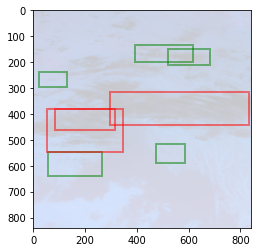

In [150]:
#transform1=transforms.Compose([transforms.ColorJitter(hue=0.1)])
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
imshow(inp, box,turb)


In [151]:
box

array([[298., 315., 833., 443.],
       [ 83., 379., 315., 463.],
       [ 59., 546., 267., 638.],
       [519., 148., 682., 210.],
       [392., 134., 616., 199.],
       [ 54., 382., 346., 545.],
       [ 24., 239., 130., 295.],
       [475., 515., 585., 591.]], dtype=float32)

In [152]:
turb

[2, 2, 1, 1, 1, 2, 1, 1]

## Fast R-Cnn model

In [ ]:
import torchvision.models as models

In [ ]:
51/840 #scaling factor 

0.060714285714285714

In [ ]:
  def propose_roi():
    #assume 32 batch size
    list_roi = []
    for i in range(32):
      dummy = torch.zeros([10,4], dtype=torch.float32)
      for j in range(10):
        x1 = j*84
        y1 = j*84
        x2 = (j+1)*84
        y2 = (j+1)*84
        dummy[j][0] = x1
        dummy[j][1] = y1
        dummy[j][2] = x2
        dummy[j][3] = x2
      list_roi.append(dummy)
    return list_roi

In [30]:
class Fast_R_cnn(nn.Module):
  def __init__(self, roi_size, scaling_factor):
    super(Fast_R_cnn, self).__init__()
    self.roi_size = roi_size
    self.scaling_factor = scaling_factor
    alexnet = models.alexnet(pretrained=True)
    #structure of alexnet could be modified if performance is bad
    self.alexnet = nn.Sequential(*list(alexnet.children())[:-2])
    self.alexnet[0][12]=nn.Identity() 

    self.ROI_pooling_layer = torchvision.ops.roi_pool



    ## FCs to produced ROI feature vectors
    self.ROI_head = nn.Sequential(
      nn.Linear(in_features=43264, out_features=21632, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=21632, out_features=10816, bias=True),
      nn.ReLU(inplace=True),
      # nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=10816, out_features=3000, bias=True)
      # nn.ReLU(inplace=True),
      # nn.Dropout(p=0.5, inplace=False),
      # nn.Linear(in_features=5000, out_features=5000, bias=True),
      # nn.ReLU(inplace=True),
      # nn.Linear(in_features=5000, out_features=3000, bias=True)
    )

    n_class = 2
    ## FCs for softmax 
    self.classficiation_label = nn.Sequential(
      nn.Linear(3000, 3), #Because 3 classes
      nn.Softmax()
    )

    ## FCs for bbox regressor 
    self.fc_before_regressor = nn.Linear(3000, 2 * 4)
    ## input using pool5 fectures and output for weigths for the bounding box calculation
    self.regressor = nn.Linear(3000, 2 * 4)
    





  def forward(self, images_data, roi_list):

    conv_feature_map = self.alexnet(images_data)
    # print(conv_feature_map.shape)

    proposed_roi = roi_list

    roi_pooling_result = self.ROI_pooling_layer(input = conv_feature_map, boxes= proposed_roi, output_size = self.roi_size, spatial_scale= self.scaling_factor)

    print(roi_pooling_result.shape)


    roi = torch.reshape(roi_pooling_result, (2*10,43264))


    # #ROI feature vector size (2*#roi,3000)
    ROI_feature = self.ROI_head(roi)

    # # Classification label 
    result_labels_probabilities = self.classficiation_label(ROI_feature)
    print(result_labels_probabilities.shape)
    print(result_labels_probabilities[0])

    # # BBOX Regresor
    # # Let bk = (bkx,bky,bkh,bkw) be the output for class k (k = 1,2) from the FC layer just before the bbox regressor in Figure 2
    bk = self.fc_before_regressor(ROI_feature)
    

    d_bk = self.regressor(ROI_feature)
    
    print(bk.shape)
    print(d_bk.shape)


    # (x,y,w,h,x,y,w,h) first 4 is coordinate for class 1, second 4 is coordinate for class 2
    bk_wh_1 = bk[:,2:4] 
    bk_wh_2 = bk[:,6:8]

    # bk_w = torch.cat([bk_w_1,bk_w_2], 1)
    # bk_h = torch.cat([bk_h_1,bk_h_2], 1)
    bk_w_h =  torch.cat([bk_wh_1,bk_wh_1,bk_wh_2,bk_wh_2], 1)

    b_hat = bk_w_h*d_bk
    # print(b_hat.shape)

    b_hat[:,0:2] = b_hat[:,0:2] + bk[:,0:2]
    b_hat[:,4:6] = b_hat[:,4:6] + bk[:,4:6]

    
    # result_labels_probabilities = SIZE(BATCH_SIZE*ROI_PER_IMAGE, 3) B_HAT = SIZE(BATCH_SIZE*ROI_PER_IMAGE, 2*4)
    return result_labels_probabilities, b_hat



  


## Labeling ROI for each image

## Training 

In [ ]:
def fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = t.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [ ]:
loss_crossentropy = nn.CrossEntropyLoss()
loss_l1_loss = nn.SmoothL1Loss()



In [ ]:
for images_data in enumerate(dataloaders['train']):
  x, y = images_data
  imgs, boxes, turbs = y

  imgs_tensor = torch.zeros([len(imgs),3,840,840])



  for i in range(len(imgs)):
    imgs_tensor[i] = imgs[i]

  roi_list = propose_roi() #dummy function


  model = Fast_R_cnn(roi_size=13,scaling_factor=float(51/840))
  model.train()
  result = model(imgs_tensor, roi_list)

  


  # imgs = np.array(imgs_list)
  # imgs = torch.tensor(imgs)
  # print(x)
  # print(type(y))
  # print(imgs_tensor.shape)
  # print(boxes[31])
  # print(turbs[31])
  break
  

torch.Size([320, 256, 13, 13])
torch.Size([320, 3])
tensor([0.3341, 0.3321, 0.3337], grad_fn=<SelectBackward>)
torch.Size([320, 8])
torch.Size([320, 8])
torch.Size([320, 8])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


##per image proposed ROI 

In [ ]:
def extractImgbyRoI(img, Coords):
  (x_min, y_min, x_max, y_max) = Coords[0]
  result = img[:, y_min:y_max, x_min:x_max]
  for i in range(1, len(Coords)):
    (x_min, y_min, x_max, y_max) = Coords[i]
    result = np.concatenate((result, img[:, y_min:y_max, x_min:x_max]), axis=2)
  return np.array(result)

In [ ]:
def myImgShow(img):
  img = img.transpose((1, 2, 0))/255
  #img = img.numpy().transpose((1, 2, 0))/255
  plt.imshow(img)

In [ ]:
def constructNeighbourGrid():
  size = 10
  neighbourGrid = []
 
  for i in range(size):
    for j in range(size):
      background = np.zeros((10, 10))
      #background[i][j] = 1
      # Dilation
      if i-1 >= 0: background[i-1][j] = 1
      if i+1 < size: background[i+1][j] = 1
      if j-1 >= 0: background[i][j-1] = 1
      if j+1 < size: background[i][j+1] = 1

      background = background.flatten()
      neighbourGrid.append(background == 1)

  return np.array(neighbourGrid)

In [ ]:
def initCoord(img, size):
  _, h, w = img.shape
  sub_h, sub_w = math.floor(h/size), math.floor(w/size)
  RoIs = np.array([[[j*sub_w, i*sub_h, (j+1)*sub_w-1, (i+1)*sub_h-1] for j in range(size)] for i in range(size)])
  RoIs = RoIs.reshape(size*size, 4)
  return RoIs

In [ ]:
def initRegions(size):
  return set([(i) for i in range(size)])

In [ ]:
def regionsToCoord(Coords, regions):
  regions_list = tuple2list(regions)
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res

In [ ]:
def regionsToCoord_test(Coords, regions):
  print(regions)
  regions_list = tuple2list(regions)
  print(regions_list[0])
  print(Coords[regions_list[0]].reshape(1, 4))
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res

In [ ]:
def getHist(img):
  D, _, _ = img.shape
  histogram = []
  for channel_idx in range(D):
    h, _ = np.histogram(img[channel_idx, :, :], bins=25)
    histogram = histogram + list(h)
  histogram = np.array(histogram/np.linalg.norm(histogram, 1))
  return histogram

In [ ]:
def sim(region1, region2):
  histogram1 = getHist(region1)
  histogram2 = getHist(region2)

  sim = np.vstack((histogram1, histogram2))
  sim = np.amin(sim, 0)
  sim = sim.sum()

  return sim

In [ ]:
def findNeighbour(regions, size):
  neighbourGrid = np.zeros((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 1
  neighbourGrid = neighbourGrid.reshape((size, size))
  neighbourGrid = ndimage.binary_dilation(neighbourGrid).astype(neighbourGrid.dtype)
  neighbourGrid = neighbourGrid.reshape((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 0
  return np.where(neighbourGrid == 1)[0]

In [ ]:
def tuple2list(input):
  if type(input) == int:
    return [input]
  res = []
  for element in input:
    if type(element) == tuple:
      res = res + list(element)
    else:
      res.append(element)
  return res


In [ ]:
def removeEnclosedRegion(regions, newR):
  redundance = set()
  for t in regions:
    if set(t).issubset(newR):
      redundance.add(t)

  regions.symmetric_difference_update(redundance)
  return regions

In [ ]:
def cropRect(RoIs, regions):
  res = RoIs
  for region in regions:
    coords = regionsToCoord(RoIs, region)

    coord_max = np.amax(coords, axis=0)
    coord_min = np.amin(coords, axis=0)

    vector = [coord_min[0], coord_min[1], coord_max[2], coord_max[3]]
    res = np.vstack((res, vector))

  return np.array(res)

In [179]:
def genRoIsperImg(im, size): 
  RoIs = initCoord(im, size)
  regions = initRegions(size*size)

  neighbourGrid = constructNeighbourGrid()

  simGrid = set()
  for i in range(size*size):
    for j in range(i, size*size):
      if neighbourGrid[i][j]:
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, [i]))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [j]))
        simGrid.add((i, j, sim(img1, img2)))

  regions_merged = set()
  current_merged_regions = set()
  i = 0
  while len(simGrid) > 0:
  #for i in range(20):
    # print('itr#:', i, " with size= ", len(simGrid))
    i = i+1
    region1, region2, _ = max(simGrid, key=lambda x:x[2])
    #print("region1 = ", region1)
    #print("region2 = ", region2)
    newRegion = set()
    newRegion.update(tuple2list(region1))
    newRegion.update(tuple2list(region2))
    regions_merged.add(tuple(newRegion))
    current_merged_regions = removeEnclosedRegion(current_merged_regions, tuple(newRegion))
    current_merged_regions.add(tuple(newRegion))
    removeList = list(filter(lambda x: x[0] == region1 or x[1] == region1, simGrid))
    #print("remove one = ", removeList)
    c1 = len(removeList)
    simGrid.difference_update(removeList)
    removeList = list(filter(lambda x: x[0] == region2 or x[1] == region2, simGrid))
    #print("remove two = ", removeList)
    c1 = c1 + len(removeList)
    #print("no of removal = ", c1)
    simGrid.difference_update(removeList)

    neighbourRegions = findNeighbour(newRegion, 10)
    #print("neigbour regions = ", neighbourRegions)
    for j in range(len(neighbourRegions)):
      neighbourRegion = neighbourRegions[j]
      #print("==== current neibh = ", neighbourRegion)
      counted = False
      for region in filter(lambda x: neighbourRegion in x, current_merged_regions):
        #print("region = ", region)
        counted = True
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, region))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

      if counted:
        #print(neighbourRegion, ' is counted')
        continue

      for region in filter(lambda x:x==neighbourRegion, regions):
        #print("single region = ", region)
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [region]))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

    if len(simGrid) <= 0:
      break
  
  res = cropRect(RoIs, regions_merged)
  res = set([tuple(ele) for ele in res])
  res = np.array(list(res))
  # print("finish")
  return res
    #print(regions_merged)
    #print(len(simGrid))

In [154]:
train=MyDataset(datatype='train', transform=None)

im, box, turb = train[0]
box = box.astype('int32') 
size = 10

v = genRoIsperImg(im, size)

itr#: 0  with size=  180
itr#: 1  with size=  179
itr#: 2  with size=  178
itr#: 3  with size=  177
itr#: 4  with size=  176
itr#: 5  with size=  175
itr#: 6  with size=  173
itr#: 7  with size=  172
itr#: 8  with size=  171
itr#: 9  with size=  170
itr#: 10  with size=  168
itr#: 11  with size=  167
itr#: 12  with size=  165
itr#: 13  with size=  164
itr#: 14  with size=  163
itr#: 15  with size=  161
itr#: 16  with size=  160
itr#: 17  with size=  158
itr#: 18  with size=  156
itr#: 19  with size=  155
itr#: 20  with size=  154
itr#: 21  with size=  153
itr#: 22  with size=  152
itr#: 23  with size=  150
itr#: 24  with size=  149
itr#: 25  with size=  147
itr#: 26  with size=  146
itr#: 27  with size=  145
itr#: 28  with size=  142
itr#: 29  with size=  140
itr#: 30  with size=  139
itr#: 31  with size=  136
itr#: 32  with size=  134
itr#: 33  with size=  132
itr#: 34  with size=  131
itr#: 35  with size=  129
itr#: 36  with size=  128
itr#: 37  with size=  125
itr#: 38  with size=  

In [145]:
box = box.astype('int32') 

In [161]:
v.shape

(165, 4)

In [155]:
v[0]

array([168,   0, 251,  83])

In [156]:
box[0]

array([298, 315, 833, 443], dtype=int32)

In [159]:
compute_IoU(box[1], v[100])

tensor([0.0407])

In [163]:
box.shape

(8, 4)

In [167]:
turb

[2, 2, 1, 1, 1, 2, 1, 1]

In [175]:
v[0]

array([168,   0, 251,  83])

In [174]:
for i in v:
  IoU_list = []
  for gt_box in box:
    IoU = compute_IoU(i, gt_box)
    IoU_list.append(IoU)
  most_likely_gt_box_iou_score = max(IoU_list)
  most_likely_gt_index = IoU_list.index(most_likely_gt_box_iou_score)
  gt_box_coord = box[most_likely_gt_index]
  if most_likely_gt_box_iou_score > 0:
    gt_box_class = turb[most_likely_gt_index]
  else:
    gt_box_class = 0

  print(most_likely_gt_box_iou_score, most_likely_gt_index, gt_box_coord, gt_box_class)

  

tensor([0.]) 0 [298 315 833 443] 0
tensor([0.3805]) 7 [475 515 585 591] 1
tensor([0.3244]) 5 [ 54 382 346 545] 2
tensor([0.5706]) 0 [298 315 833 443] 2
tensor([0.2149]) 2 [ 59 546 267 638] 1
tensor([0.3286]) 6 [ 24 239 130 295] 1
tensor([0.1918]) 3 [519 148 682 210] 1
tensor([0.2561]) 7 [475 515 585 591] 1
tensor([0.3728]) 2 [ 59 546 267 638] 1
tensor([0.6017]) 1 [ 83 379 315 463] 2
tensor([0.1855]) 0 [298 315 833 443] 2
tensor([0.4118]) 5 [ 54 382 346 545] 2
tensor([0.6801]) 1 [ 83 379 315 463] 2
tensor([0.5085]) 3 [519 148 682 210] 1
tensor([0.1481]) 7 [475 515 585 591] 1
tensor([0.5378]) 0 [298 315 833 443] 2
tensor([0.]) 0 [298 315 833 443] 0
tensor([0.5246]) 1 [ 83 379 315 463] 2
tensor([0.1373]) 5 [ 54 382 346 545] 2
tensor([0.3406]) 0 [298 315 833 443] 2
tensor([0.3608]) 7 [475 515 585 591] 1
tensor([0.]) 0 [298 315 833 443] 0
tensor([0.2577]) 7 [475 515 585 591] 1
tensor([0.7093]) 2 [ 59 546 267 638] 1
tensor([0.4018]) 0 [298 315 833 443] 2
tensor([0.]) 0 [298 315 833 443] 0
te